In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
#! /usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import gc

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch import nn

from dataloader import cifar10
from models import VGG11
from src import freeze_influence, hessians, selection

device = "cuda" if torch.cuda.is_available() else "cpu"
target_removal_label = 0

In [30]:
def load_net(net, path, _assert=True):
    if _assert:
        assert os.path.isfile(path), f"Error: no checkpoint file found! {path}"
    
    if not os.path.isfile(path):
        return None
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint["net"])
    return net


def save_net(net, path):
    dir, filename = os.path.split(path)
    if not os.path.isdir(dir):
        os.makedirs(dir)

    state = {
        "net": net.state_dict(),
    }
    torch.save(state, path)


def test(net, dataloader, criterion, label, include):
    net.eval()
    with torch.no_grad():
        net_loss = 0
        correct = 0
        total = 0
        num_data = 0
        for _, (inputs, targets) in enumerate(dataloader):
            if include:
                idx = targets == label
            else:
                idx = targets != label
            inputs = inputs[idx]
            targets = targets[idx]
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            net_loss += loss * len(inputs)
            num_data +=  len(inputs)

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()

        accuracy = correct / total * 100
        net_loss /= num_data
        return net_loss, accuracy

def influence_test(net, dataloader, criterion, target_label):
    def sample_test(net, criterion, inputs, targets):
        net.eval()
        with torch.no_grad():
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)
            correct = predicted.eq(targets).sum().item()

            return loss, correct

    self_loss = 0
    self_correct = 0
    num_self_inputs = 0
    
    exclusive_loss = 0
    exclusive_correct = 0
    num_exclusive_inputs = 0
    
    for _, (inputs, targets) in enumerate(dataloader):
        target_idx = (targets == target_label)
        batch_self_loss, batch_self_correct = sample_test(net, criterion, inputs[target_idx], targets[target_idx])
        batch_exclusive_loss, batch_exclusive_correct = sample_test(net, criterion, inputs[~target_idx], targets[~target_idx])
        
        len_self_batch = len(inputs[target_idx])
        self_loss += batch_self_loss * len_self_batch
        self_correct += batch_self_correct
        num_self_inputs += len_self_batch
        
        len_exclusive_batch = len(inputs[~target_idx])
        exclusive_loss += batch_exclusive_loss * len_exclusive_batch
        exclusive_correct += batch_exclusive_correct
        num_exclusive_inputs += len_exclusive_batch
        
    self_loss /= num_self_inputs
    self_acc = self_correct / num_self_inputs * 100
    exclusive_loss /= num_exclusive_inputs
    exclusive_acc = exclusive_correct / num_exclusive_inputs * 100
    
    return self_loss, self_acc, exclusive_loss, exclusive_acc

def projected_influence(net, total_loss, target_loss, index_list, tol, step, max_iter, verbose):
    num_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
    full_param_index_list = np.arange(num_param)
    influence = hessians.generalized_influence(
        net, total_loss, target_loss, full_param_index_list, tol=tol, step=step, max_iter=max_iter, verbose=verbose
    )
    return influence[idx]

def f1_score(self_acc, test_acc):
    self_acc /= 100
    test_acc /= 100
    if self_acc == 1 and test_acc == 0:
        return 0
    return 2 * (1 - self_acc) * test_acc / (1 - self_acc + test_acc)

In [16]:
net = VGG11().to(device)
net_name = "VGG11"

if device == "cuda":
    cudnn.benchmark = True

net_path = f"checkpoints/tab2/{net_name}/cross_entropy/ckpt_0.0.pth"
net = load_net(net, net_path)

net.eval()
num_param = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(
    f"==> Building {net_name} finished. "
    + f"\n    Number of parameters: {num_param}"
)

criterion = nn.CrossEntropyLoss()

# Data
print("==> Preparing data..")
batch_size = 512
num_workers = 16
num_sample_batch = 1
num_target_sample = 1024

data_loader = cifar10.CIFAR10DataLoader(batch_size, num_workers, validation=False)
train_loader, test_loader = data_loader.get_data_loaders()

loss, original_acc = test(net, test_loader, criterion, 11, False)
print(
    f"Original loss and acc : {loss:.4f}, {acc:.2f}%"
)

==> Building VGG11 finished. 
    Number of parameters: 9231114
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Original loss and acc : 0.3518, 91.50%


In [5]:
verbose = False
num_exp = 30

removal_inputs = list()
removal_targets = list()
for batch_idx, (inputs, targets) in enumerate(train_loader):
    idx = targets == target_removal_label
    removal_inputs.append(inputs[idx])
    removal_targets.append(targets[idx])
removal_inputs = torch.cat(removal_inputs)
removal_targets = torch.cat(removal_targets)

ratio_list = np.arange(2, 21, 3) / 100
ratio_list = np.append(ratio_list, 1.)
result_list_LowestKOutputs = []
result_list_LowestKGradients = []
result_list_HighestKOutputs = []
result_list_HighestKGradients = []
result_list_Random = []
tol = 1e-9

parser_list = [selection.LowestKOutputs,
              selection.LowestKGradients,
              selection.HighestKOutputs,
              selection.HighestKGradients,
              selection.Random,]

In [6]:
for i in range(num_exp):
    print(f"==================Iteration {i}==================")
    sample_idx = np.random.choice(len(removal_inputs), num_target_sample, replace=False)
    for param_ratio in ratio_list:
        for parser in parser_list:

            print(f"{parser.__name__} - ratio: {int(param_ratio*100)}%")
            # Initialize network
            net = load_net(net, net_path)

            # Compute total loss
            total_loss = 0
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                if batch_idx >= num_sample_batch:
                    break
                idx = targets != target_removal_label
                inputs, targets = inputs[idx], targets[idx]
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                total_loss += criterion(outputs, targets)

            # Sampling the target removal data
            sample_removal_inputs = removal_inputs[sample_idx]
            sample_removal_targets = removal_targets[sample_idx]
            
            # Make hooks
            net_parser = parser(net, param_ratio)
            net_parser.register_hooks()

            if isinstance(net_parser, selection.HighestKGradients) or \
               isinstance(net_parser, selection.LowestKGradients):
                # Compute target loss
                target_loss = (
                    criterion(net(sample_removal_inputs.to(device)), sample_removal_targets.to(device))
                    * len(removal_inputs)
                    / (len(train_loader.dataset) - len(removal_inputs))
                )
                target_loss.backward()
                net_parser.remove_hooks()

            target_loss = (
                criterion(net(sample_removal_inputs.to(device)), sample_removal_targets.to(device))
                * len(removal_inputs)
                / (len(train_loader.dataset) - len(removal_inputs))
            )
            
            # Delete hooks
            index_list = net_parser.get_parameters()
            net_parser.remove_hooks()
            
            influence = hessians.generalized_influence(
                net, total_loss, target_loss, index_list, tol=tol, step=7, max_iter=200, verbose=verbose
            )
            del target_loss, total_loss
            gc.collect()
            torch.cuda.empty_cache()
            
            influence = influence * 0.06 / torch.norm(influence)
                
            scale = 1
            score = 0
            best_score = -1
            count = 1
            save_path = (
                f"checkpoints/tab1/{net_name}/{net_parser.__class__.__name__}/{param_ratio}_{i}.pth"
            )
            while True:
                net_parser.update_network(influence * scale)

#                 self_loss, self_acc = test(net, test_loader, criterion, target_removal_label, True)
#                 exclusive_loss, exclusive_acc = test(net, test_loader, criterion, target_removal_label, False)
                self_loss, self_acc, exclusive_loss, exclusive_acc = influence_test(net, test_loader, 
                                                                                    criterion, target_removal_label)
                score = f1_score(self_acc, exclusive_acc)
                
                if best_score < score and self_acc < 0.5:
                    best_result = [exclusive_acc, exclusive_loss, self_acc, self_loss, score]
                    best_score = score
                    save_net(net, save_path)
                    
                if verbose:
                    print(
                    f"{count} - test acc: {exclusive_acc:2.2f}, test loss: {exclusive_loss:.4f} |" +
                    f" self-acc: {self_acc:2.2f}%, self loss: {self_loss:.4f} | score: {score:.7f}",
                    end='\r'
                    )

                if self_acc < 0.1 or count >= 200:
                    if parser == selection.LowestKOutputs:
                        result_list_LowestKOutputs += best_result
                    elif parser == selection.LowestKGradients:
                        result_list_LowestKGradients += best_result
                    elif parser == selection.HighestKOutputs:
                        result_list_HighestKOutputs += best_result
                    elif parser == selection.HighestKGradients:
                        result_list_HighestKGradients += best_result
                    else:
                        result_list_Random += best_result
                    
                    print(f"test acc: {best_result[0]:2.2f}, test loss: {best_result[1]:.4f} | " +
                          f"self-acc: {best_result[2]:2.2f}%, self loss: {best_result[3]:.4f} | " +
                          f"Score: {best_result[4]:.7f}" + " " * 20) 
                    break
                elif count >= 20 and best_score < 0.2:
                    scale = 5
                elif count >= 50 and best_score < 0.5:
                    print(f"test acc: {best_result[0]:2.2f}, test loss: {best_result[1]:.4f} | " +
                          f"self-acc: {best_result[2]:2.2f}%, self loss: {best_result[3]:.4f} | " +
                          f"Score: {best_result[4]:.7f}" + " " * 20) 
                    break

                count += 1
                
        print("")

==================Iteration 0==================
LowestKOutputs - ratio: 2%
test acc: 11.08, test loss: 288.4673 | self-acc: 0.20%, self loss: 60.4136 | Score: 0.1994200                    
LowestKGradients - ratio: 2%
test acc: 44.13, test loss: 2.4039 | self-acc: 0.30%, self loss: 5.9326 | Score: 0.6118322                    
HighestKOutputs - ratio: 2%
test acc: 90.10, test loss: 0.3692 | self-acc: 0.40%, self loss: 3.5131 | Score: 0.9461212                    
HighestKGradients - ratio: 2%
test acc: 88.62, test loss: 0.3986 | self-acc: 0.00%, self loss: 3.4407 | Score: 0.9396795                    
Random - ratio: 2%
test acc: 82.73, test loss: 0.6159 | self-acc: 0.10%, self loss: 5.6847 | Score: 0.9050987                    

LowestKOutputs - ratio: 5%
test acc: 38.54, test loss: 1.9822 | self-acc: 0.00%, self loss: 3.1953 | Score: 0.5564199                    
LowestKGradients - ratio: 5%
test acc: 49.88, test loss: 1.9734 | self-acc: 0.30%, self loss: 6.5694 | Score: 0.6649135   

test acc: 81.89, test loss: 0.6392 | self-acc: 0.00%, self loss: 5.9520 | Score: 0.9004276                    

LowestKOutputs - ratio: 14%
test acc: 77.54, test loss: 0.7678 | self-acc: 0.00%, self loss: 3.5065 | Score: 0.8735215                    
LowestKGradients - ratio: 14%
test acc: 50.50, test loss: 2.2544 | self-acc: 0.30%, self loss: 6.5888 | Score: 0.6704194                    
HighestKOutputs - ratio: 14%
test acc: 90.07, test loss: 0.3487 | self-acc: 0.00%, self loss: 4.6674 | Score: 0.9477376                    
HighestKGradients - ratio: 14%
test acc: 90.49, test loss: 0.3415 | self-acc: 0.00%, self loss: 4.4324 | Score: 0.9500700                    
Random - ratio: 14%
test acc: 80.78, test loss: 0.6608 | self-acc: 0.10%, self loss: 6.0902 | Score: 0.8932698                    

LowestKOutputs - ratio: 17%
test acc: 81.30, test loss: 0.6624 | self-acc: 0.00%, self loss: 4.0207 | Score: 0.8968560                    
LowestKGradients - ratio: 17%
test acc: 55.07, test los

test acc: 80.12, test loss: 0.8001 | self-acc: 0.00%, self loss: 8.6480 | Score: 0.8896428                    
Random - ratio: 100%
test acc: 80.13, test loss: 0.8002 | self-acc: 0.00%, self loss: 8.6480 | Score: 0.8897113                    

==================Iteration 3==================
LowestKOutputs - ratio: 2%
test acc: 11.11, test loss: 26.7628 | self-acc: 0.00%, self loss: 11.9293 | Score: 0.2000000                    
LowestKGradients - ratio: 2%
test acc: 56.93, test loss: 1.9155 | self-acc: 0.40%, self loss: 5.1494 | Score: 0.7245179                    
HighestKOutputs - ratio: 2%
test acc: 89.40, test loss: 0.3948 | self-acc: 0.10%, self loss: 3.9859 | Score: 0.9435880                    
HighestKGradients - ratio: 2%
test acc: 65.80, test loss: 1.1844 | self-acc: 0.40%, self loss: 3.7231 | Score: 0.7924643                    
Random - ratio: 2%
test acc: 87.06, test loss: 0.4707 | self-acc: 0.10%, self loss: 6.4704 | Score: 0.9303655                    

LowestKOutputs - 

test acc: 86.97, test loss: 0.5207 | self-acc: 0.40%, self loss: 6.2190 | Score: 0.9285560                    
HighestKGradients - ratio: 11%
test acc: 88.79, test loss: 0.4600 | self-acc: 0.20%, self loss: 6.5326 | Score: 0.9397299                    
Random - ratio: 11%
test acc: 82.68, test loss: 0.6830 | self-acc: 0.20%, self loss: 8.7729 | Score: 0.9043558                    

LowestKOutputs - ratio: 14%
test acc: 64.93, test loss: 1.5431 | self-acc: 0.30%, self loss: 8.9246 | Score: 0.7864572                    
LowestKGradients - ratio: 14%
test acc: 52.51, test loss: 2.1467 | self-acc: 0.00%, self loss: 6.5896 | Score: 0.6886201                    
HighestKOutputs - ratio: 14%
test acc: 84.87, test loss: 0.6085 | self-acc: 0.10%, self loss: 7.1786 | Score: 0.9177175                    
HighestKGradients - ratio: 14%
test acc: 88.79, test loss: 0.4493 | self-acc: 0.40%, self loss: 6.6581 | Score: 0.9388423                    
Random - ratio: 14%
test acc: 82.10, test loss: 0.716

test acc: 78.01, test loss: 0.9539 | self-acc: 0.10%, self loss: 8.4788 | Score: 0.8760903                    
HighestKOutputs - ratio: 100%
test acc: 78.01, test loss: 0.9538 | self-acc: 0.10%, self loss: 8.4789 | Score: 0.8760903                    
HighestKGradients - ratio: 100%
test acc: 78.01, test loss: 0.9539 | self-acc: 0.10%, self loss: 8.4793 | Score: 0.8760903                    
Random - ratio: 100%
test acc: 78.01, test loss: 0.9538 | self-acc: 0.10%, self loss: 8.4787 | Score: 0.8760903                    

==================Iteration 6==================
LowestKOutputs - ratio: 2%
test acc: 30.28, test loss: 3.3570 | self-acc: 0.20%, self loss: 7.2684 | Score: 0.4646024                    
LowestKGradients - ratio: 2%
test acc: 32.43, test loss: 2.1854 | self-acc: 0.30%, self loss: 4.1053 | Score: 0.4894455                    
HighestKOutputs - ratio: 2%
test acc: 90.48, test loss: 0.3744 | self-acc: 0.10%, self loss: 4.2283 | Score: 0.9495573                    
Highest

test acc: 47.08, test loss: 2.9923 | self-acc: 0.30%, self loss: 11.5565 | Score: 0.6395593                    
LowestKGradients - ratio: 11%
test acc: 66.13, test loss: 1.2781 | self-acc: 0.00%, self loss: 7.2313 | Score: 0.7961477                    
HighestKOutputs - ratio: 11%
test acc: 88.07, test loss: 0.4711 | self-acc: 0.20%, self loss: 6.0589 | Score: 0.9356693                    
HighestKGradients - ratio: 11%
test acc: 89.27, test loss: 0.4297 | self-acc: 0.30%, self loss: 6.3892 | Score: 0.9419531                    
Random - ratio: 11%
test acc: 84.08, test loss: 0.6654 | self-acc: 0.10%, self loss: 10.1120 | Score: 0.9130853                    

LowestKOutputs - ratio: 14%
test acc: 55.78, test loss: 2.1895 | self-acc: 0.20%, self loss: 10.4841 | Score: 0.7156063                    
LowestKGradients - ratio: 14%
test acc: 64.86, test loss: 1.3160 | self-acc: 0.20%, self loss: 6.9901 | Score: 0.7861969                    
HighestKOutputs - ratio: 14%
test acc: 87.60, test 

test acc: 85.29, test loss: 0.5251 | self-acc: 0.20%, self loss: 7.2807 | Score: 0.9197560                    

LowestKOutputs - ratio: 100%
test acc: 79.32, test loss: 0.8726 | self-acc: 0.10%, self loss: 8.3949 | Score: 0.8842977                    
LowestKGradients - ratio: 100%
test acc: 79.32, test loss: 0.8728 | self-acc: 0.10%, self loss: 8.3954 | Score: 0.8842977                    
HighestKOutputs - ratio: 100%
test acc: 79.32, test loss: 0.8727 | self-acc: 0.10%, self loss: 8.3952 | Score: 0.8842977                    
HighestKGradients - ratio: 100%
test acc: 79.34, test loss: 0.8726 | self-acc: 0.10%, self loss: 8.3948 | Score: 0.8844358                    
Random - ratio: 100%
test acc: 79.32, test loss: 0.8727 | self-acc: 0.10%, self loss: 8.3950 | Score: 0.8842977                    

==================Iteration 9==================
LowestKOutputs - ratio: 2%
test acc: 30.13, test loss: 2.8919 | self-acc: 0.40%, self loss: 5.5306 | Score: 0.4626845                    
Low

test acc: 90.87, test loss: 0.3362 | self-acc: 0.00%, self loss: 4.8517 | Score: 0.9521481                    
Random - ratio: 8%
test acc: 86.14, test loss: 0.4829 | self-acc: 0.10%, self loss: 6.5892 | Score: 0.9251370                    

LowestKOutputs - ratio: 11%
test acc: 62.27, test loss: 1.4450 | self-acc: 0.20%, self loss: 6.9801 | Score: 0.7668712                    
LowestKGradients - ratio: 11%
test acc: 15.88, test loss: 5.3369 | self-acc: 0.00%, self loss: 9.0463 | Score: 0.2740435                    
HighestKOutputs - ratio: 11%
test acc: 89.79, test loss: 0.3816 | self-acc: 0.20%, self loss: 4.9674 | Score: 0.9453013                    
HighestKGradients - ratio: 11%
test acc: 90.72, test loss: 0.3450 | self-acc: 0.10%, self loss: 5.2519 | Score: 0.9509017                    
Random - ratio: 11%
test acc: 87.02, test loss: 0.4639 | self-acc: 0.30%, self loss: 6.7510 | Score: 0.9293072                    

LowestKOutputs - ratio: 14%
test acc: 60.18, test loss: 1.4909 |

test acc: 85.92, test loss: 0.5596 | self-acc: 0.40%, self loss: 7.6391 | Score: 0.9225691                    
HighestKGradients - ratio: 20%
test acc: 89.34, test loss: 0.4175 | self-acc: 0.10%, self loss: 6.9378 | Score: 0.9432784                    
Random - ratio: 20%
test acc: 84.67, test loss: 0.6240 | self-acc: 0.10%, self loss: 9.0127 | Score: 0.9165469                    

LowestKOutputs - ratio: 100%
test acc: 74.80, test loss: 1.2046 | self-acc: 0.00%, self loss: 9.9224 | Score: 0.8558352                    
LowestKGradients - ratio: 100%
test acc: 74.80, test loss: 1.2047 | self-acc: 0.00%, self loss: 9.9223 | Score: 0.8558352                    
HighestKOutputs - ratio: 100%
test acc: 74.80, test loss: 1.2047 | self-acc: 0.00%, self loss: 9.9221 | Score: 0.8558352                    
HighestKGradients - ratio: 100%
test acc: 74.80, test loss: 1.2047 | self-acc: 0.00%, self loss: 9.9221 | Score: 0.8558352                    
Random - ratio: 100%
test acc: 74.80, test loss: 

test acc: 62.90, test loss: 1.4180 | self-acc: 0.30%, self loss: 7.0026 | Score: 0.7713567                    
HighestKOutputs - ratio: 8%
test acc: 90.83, test loss: 0.3471 | self-acc: 0.30%, self loss: 4.3065 | Score: 0.9506036                    
HighestKGradients - ratio: 8%
test acc: 90.79, test loss: 0.3517 | self-acc: 0.00%, self loss: 4.6010 | Score: 0.9517209                    
Random - ratio: 8%
test acc: 87.37, test loss: 0.4438 | self-acc: 0.40%, self loss: 7.2629 | Score: 0.9308312                    

LowestKOutputs - ratio: 11%
test acc: 54.24, test loss: 2.0028 | self-acc: 0.10%, self loss: 9.0564 | Score: 0.7031093                    
LowestKGradients - ratio: 11%
test acc: 59.70, test loss: 1.4925 | self-acc: 0.30%, self loss: 7.4107 | Score: 0.7468118                    
HighestKOutputs - ratio: 11%
test acc: 90.21, test loss: 0.3749 | self-acc: 0.20%, self loss: 5.2108 | Score: 0.9476360                    
HighestKGradients - ratio: 11%
test acc: 90.70, test loss:

test acc: 86.80, test loss: 0.4632 | self-acc: 0.30%, self loss: 5.1931 | Score: 0.9280386                    
LowestKGradients - ratio: 20%
test acc: 68.17, test loss: 1.2276 | self-acc: 0.20%, self loss: 7.4378 | Score: 0.8100456                    
HighestKOutputs - ratio: 20%
test acc: 89.31, test loss: 0.3760 | self-acc: 0.00%, self loss: 5.7048 | Score: 0.9435380                    
HighestKGradients - ratio: 20%
test acc: 90.97, test loss: 0.3270 | self-acc: 0.00%, self loss: 5.6221 | Score: 0.9526968                    
Random - ratio: 20%
test acc: 88.49, test loss: 0.3948 | self-acc: 0.30%, self loss: 6.6205 | Score: 0.9376050                    

LowestKOutputs - ratio: 100%
test acc: 81.29, test loss: 0.7491 | self-acc: 0.00%, self loss: 8.6105 | Score: 0.8967884                    
LowestKGradients - ratio: 100%
test acc: 81.29, test loss: 0.7490 | self-acc: 0.00%, self loss: 8.6105 | Score: 0.8967884                    
HighestKOutputs - ratio: 100%
test acc: 81.29, test 

test acc: 84.26, test loss: 0.5842 | self-acc: 0.10%, self loss: 6.3429 | Score: 0.9141326                    

LowestKOutputs - ratio: 8%
test acc: 64.28, test loss: 1.1336 | self-acc: 0.20%, self loss: 3.4271 | Score: 0.7819368                    
LowestKGradients - ratio: 8%
test acc: 35.94, test loss: 3.2597 | self-acc: 0.10%, self loss: 7.3224 | Score: 0.5286709                    
HighestKOutputs - ratio: 8%
test acc: 91.16, test loss: 0.3255 | self-acc: 0.10%, self loss: 3.7923 | Score: 0.9532767                    
HighestKGradients - ratio: 8%
test acc: 90.74, test loss: 0.3323 | self-acc: 0.00%, self loss: 4.2734 | Score: 0.9514767                    
Random - ratio: 8%
test acc: 85.43, test loss: 0.5160 | self-acc: 0.10%, self loss: 6.5348 | Score: 0.9210205                    

LowestKOutputs - ratio: 11%
test acc: 79.38, test loss: 0.7126 | self-acc: 0.00%, self loss: 3.4938 | Score: 0.8850347                    
LowestKGradients - ratio: 11%
test acc: 61.72, test loss: 1.

test acc: 90.46, test loss: 0.3403 | self-acc: 0.20%, self loss: 4.9250 | Score: 0.9489830                    
Random - ratio: 17%
test acc: 86.57, test loss: 0.4745 | self-acc: 0.40%, self loss: 6.2392 | Score: 0.9262711                    

LowestKOutputs - ratio: 20%
test acc: 86.49, test loss: 0.4742 | self-acc: 0.20%, self loss: 5.4411 | Score: 0.9266888                    
LowestKGradients - ratio: 20%
test acc: 59.26, test loss: 1.8228 | self-acc: 0.40%, self loss: 7.8116 | Score: 0.7430465                    
HighestKOutputs - ratio: 20%
test acc: 88.19, test loss: 0.4169 | self-acc: 0.00%, self loss: 5.7740 | Score: 0.9372380                    
HighestKGradients - ratio: 20%
test acc: 90.43, test loss: 0.3420 | self-acc: 0.20%, self loss: 5.0005 | Score: 0.9488607                    
Random - ratio: 20%
test acc: 86.51, test loss: 0.4956 | self-acc: 0.40%, self loss: 6.7364 | Score: 0.9259530                    

LowestKOutputs - ratio: 100%
test acc: 78.66, test loss: 0.9021

test acc: 90.91, test loss: 0.3552 | self-acc: 0.20%, self loss: 3.8818 | Score: 0.9514840                    
HighestKGradients - ratio: 5%
test acc: 90.37, test loss: 0.3831 | self-acc: 0.10%, self loss: 4.6095 | Score: 0.9489450                    
Random - ratio: 5%
test acc: 85.58, test loss: 0.5803 | self-acc: 0.00%, self loss: 8.5441 | Score: 0.9222848                    

LowestKOutputs - ratio: 8%
test acc: 49.04, test loss: 2.3721 | self-acc: 0.40%, self loss: 8.8548 | Score: 0.6572498                    
LowestKGradients - ratio: 8%
test acc: 65.23, test loss: 1.2123 | self-acc: 0.10%, self loss: 5.8591 | Score: 0.7892786                    
HighestKOutputs - ratio: 8%
test acc: 89.73, test loss: 0.4066 | self-acc: 0.10%, self loss: 4.8506 | Score: 0.9454414                    
HighestKGradients - ratio: 8%
test acc: 90.02, test loss: 0.3983 | self-acc: 0.10%, self loss: 5.6475 | Score: 0.9470424                    
Random - ratio: 8%
test acc: 85.52, test loss: 0.5856 | sel

test acc: 38.96, test loss: 2.2781 | self-acc: 0.30%, self loss: 5.3344 | Score: 0.5602183                    
HighestKOutputs - ratio: 17%
test acc: 89.09, test loss: 0.3837 | self-acc: 0.00%, self loss: 5.3862 | Score: 0.9422964                    
HighestKGradients - ratio: 17%
test acc: 90.08, test loss: 0.3491 | self-acc: 0.10%, self loss: 5.3945 | Score: 0.9473497                    
Random - ratio: 17%
test acc: 85.89, test loss: 0.5071 | self-acc: 0.30%, self loss: 6.9568 | Score: 0.9228055                    

LowestKOutputs - ratio: 20%
test acc: 86.40, test loss: 0.4610 | self-acc: 0.10%, self loss: 5.5190 | Score: 0.9266087                    
LowestKGradients - ratio: 20%
test acc: 34.62, test loss: 2.7602 | self-acc: 0.00%, self loss: 6.1017 | Score: 0.5143612                    
HighestKOutputs - ratio: 20%
test acc: 86.12, test loss: 0.4902 | self-acc: 0.00%, self loss: 6.6233 | Score: 0.9254373                    
HighestKGradients - ratio: 20%
test acc: 89.57, test lo

test acc: 34.19, test loss: 1.9701 | self-acc: 0.40%, self loss: 2.9063 | Score: 0.5090428                    
LowestKGradients - ratio: 5%
test acc: 55.21, test loss: 1.9410 | self-acc: 0.00%, self loss: 7.4544 | Score: 0.7114325                    
HighestKOutputs - ratio: 5%
test acc: 90.97, test loss: 0.3376 | self-acc: 0.00%, self loss: 3.5902 | Score: 0.9526968                    
HighestKGradients - ratio: 5%
test acc: 90.59, test loss: 0.3597 | self-acc: 0.00%, self loss: 4.1106 | Score: 0.9506209                    
Random - ratio: 5%
test acc: 82.83, test loss: 0.6146 | self-acc: 0.10%, self loss: 7.3517 | Score: 0.9056968                    

LowestKOutputs - ratio: 8%
test acc: 61.41, test loss: 1.1786 | self-acc: 0.20%, self loss: 3.4559 | Score: 0.7603482                    
LowestKGradients - ratio: 8%
test acc: 52.23, test loss: 2.4901 | self-acc: 0.00%, self loss: 8.4291 | Score: 0.6862273                    
HighestKOutputs - ratio: 8%
test acc: 90.50, test loss: 0.34

test acc: 87.84, test loss: 0.4223 | self-acc: 0.20%, self loss: 6.0237 | Score: 0.9344135                    

LowestKOutputs - ratio: 17%
test acc: 81.07, test loss: 0.6371 | self-acc: 0.30%, self loss: 4.3586 | Score: 0.8942298                    
LowestKGradients - ratio: 17%
test acc: 65.20, test loss: 1.5005 | self-acc: 0.20%, self loss: 8.0004 | Score: 0.7887224                    
HighestKOutputs - ratio: 17%
test acc: 89.49, test loss: 0.3601 | self-acc: 0.20%, self loss: 4.7156 | Score: 0.9436361                    
HighestKGradients - ratio: 17%
test acc: 90.87, test loss: 0.3163 | self-acc: 0.20%, self loss: 4.8494 | Score: 0.9512406                    
Random - ratio: 17%
test acc: 87.30, test loss: 0.4419 | self-acc: 0.20%, self loss: 6.9525 | Score: 0.9313244                    

LowestKOutputs - ratio: 20%
test acc: 86.60, test loss: 0.4433 | self-acc: 0.30%, self loss: 4.9656 | Score: 0.9268943                    
LowestKGradients - ratio: 20%
test acc: 54.43, test los

test acc: 89.52, test loss: 0.4320 | self-acc: 0.00%, self loss: 3.6328 | Score: 0.9447148                    
Random - ratio: 2%
test acc: 81.79, test loss: 0.7307 | self-acc: 0.30%, self loss: 9.7625 | Score: 0.8986062                    

LowestKOutputs - ratio: 5%
test acc: 34.09, test loss: 3.6575 | self-acc: 0.20%, self loss: 9.7639 | Score: 0.5081932                    
LowestKGradients - ratio: 5%
test acc: 48.21, test loss: 1.8998 | self-acc: 0.30%, self loss: 4.8741 | Score: 0.6499373                    
HighestKOutputs - ratio: 5%
test acc: 89.81, test loss: 0.4079 | self-acc: 0.10%, self loss: 4.6160 | Score: 0.9458729                    
HighestKGradients - ratio: 5%
test acc: 89.58, test loss: 0.4323 | self-acc: 0.00%, self loss: 5.0285 | Score: 0.9450240                    
Random - ratio: 5%
test acc: 78.60, test loss: 0.9161 | self-acc: 0.20%, self loss: 10.9348 | Score: 0.8794036                    

LowestKOutputs - ratio: 8%
test acc: 49.79, test loss: 2.6373 | self

test acc: 90.39, test loss: 0.3449 | self-acc: 0.10%, self loss: 4.8049 | Score: 0.9490675                    
HighestKGradients - ratio: 14%
test acc: 90.93, test loss: 0.3248 | self-acc: 0.00%, self loss: 5.1877 | Score: 0.9525140                    
Random - ratio: 14%
test acc: 88.49, test loss: 0.4148 | self-acc: 0.40%, self loss: 7.1674 | Score: 0.9371626                    

LowestKOutputs - ratio: 17%
test acc: 70.61, test loss: 0.9729 | self-acc: 0.10%, self loss: 5.2956 | Score: 0.8274006                    
LowestKGradients - ratio: 17%
test acc: 48.17, test loss: 2.1966 | self-acc: 0.10%, self loss: 6.6455 | Score: 0.6499572                    
HighestKOutputs - ratio: 17%
test acc: 89.92, test loss: 0.3545 | self-acc: 0.20%, self loss: 5.0195 | Score: 0.9460397                    
HighestKGradients - ratio: 17%
test acc: 90.94, test loss: 0.3201 | self-acc: 0.30%, self loss: 5.1327 | Score: 0.9512117                    
Random - ratio: 17%
test acc: 88.84, test loss: 0.379

test acc: 54.36, test loss: 1.5058 | self-acc: 0.30%, self loss: 5.0222 | Score: 0.7035448                    
HighestKOutputs - ratio: 2%
test acc: 89.80, test loss: 0.3760 | self-acc: 0.20%, self loss: 3.5799 | Score: 0.9453629                    
HighestKGradients - ratio: 2%
test acc: 86.91, test loss: 0.4981 | self-acc: 0.30%, self loss: 3.7192 | Score: 0.9286733                    
Random - ratio: 2%
test acc: 73.02, test loss: 1.0200 | self-acc: 0.40%, self loss: 7.7128 | Score: 0.8426509                    

LowestKOutputs - ratio: 5%
test acc: 51.36, test loss: 1.6518 | self-acc: 0.30%, self loss: 2.7033 | Score: 0.6779160                    
LowestKGradients - ratio: 5%
test acc: 45.60, test loss: 2.0198 | self-acc: 0.10%, self loss: 4.8061 | Score: 0.6261773                    
HighestKOutputs - ratio: 5%
test acc: 90.88, test loss: 0.3372 | self-acc: 0.00%, self loss: 3.6178 | Score: 0.9522091                    
HighestKGradients - ratio: 5%
test acc: 90.69, test loss: 0.3

test acc: 54.26, test loss: 2.3959 | self-acc: 0.10%, self loss: 10.6010 | Score: 0.7032027                    
LowestKGradients - ratio: 14%
test acc: 72.62, test loss: 1.0405 | self-acc: 0.40%, self loss: 6.2789 | Score: 0.8399814                    
HighestKOutputs - ratio: 14%
test acc: 86.44, test loss: 0.5448 | self-acc: 0.40%, self loss: 6.7881 | Score: 0.9255710                    
HighestKGradients - ratio: 14%
test acc: 88.09, test loss: 0.4693 | self-acc: 0.40%, self loss: 7.1960 | Score: 0.9349145                    
Random - ratio: 14%
test acc: 85.82, test loss: 0.5701 | self-acc: 0.40%, self loss: 9.1810 | Score: 0.9219923                    

LowestKOutputs - ratio: 17%
test acc: 69.27, test loss: 1.3302 | self-acc: 0.00%, self loss: 9.9170 | Score: 0.8184325                    
LowestKGradients - ratio: 17%
test acc: 72.90, test loss: 1.0174 | self-acc: 0.20%, self loss: 7.3044 | Score: 0.8425501                    
HighestKOutputs - ratio: 17%
test acc: 83.00, test lo

In [ ]:
num_exp = 30
mean_exclusive_acc_list = np.zeros((len(parser_list), len(ratio_list[:-1])))
var_exclusive_acc_list = np.zeros((len(parser_list), len(ratio_list[:-1])))

for j, param_ratio in enumerate(ratio_list):
    print("")
    for i, parser in enumerate(parser_list):
        print(f"{parser.__name__} - ratio: {int(param_ratio*100)}%")
        
        self_loss_list = np.empty(0)
        self_acc_list = np.empty(0)
        exclusive_loss_list = np.empty(0)
        exclusive_acc_list = np.empty(0)
        f1_score_list = np.empty(0)

        for exp_idx in range(num_exp):

            load_path = (
                f"checkpoints/tab1/{net_name}/{parser.__name__}/{param_ratio}_{exp_idx}.pth"
            )
            net = VGG11().to(device)
            net = load_net(net, load_path, False)
            if net is None:
                continue
            self_loss, self_acc, exclusive_loss, exclusive_acc = influence_test(net, test_loader, 
                                                                    criterion, target_removal_label)
            
            score = f1_score(self_acc, exclusive_acc)
            
            self_loss_list = np.append(self_loss_list, self_loss.detach().cpu().numpy())
            self_acc_list = np.append(self_acc_list, self_acc)
            exclusive_loss_list = np.append(exclusive_loss_list, exclusive_loss.detach().cpu().numpy())
            exclusive_acc_list = np.append(exclusive_acc_list, exclusive_acc)
            f1_score_list = np.append(f1_score_list, score)
            print(
            f"  test acc: {exclusive_acc:2.2f}, test loss: {exclusive_loss:.4f} | " +
            f"self-acc: {self_acc:2.2f}%, self loss: {self_loss:.4f} | score: {score:.4f}",
            end='\r'
            )
            
        mean_self_loss = np.mean(self_loss_list)
        mean_self_acc = np.mean(self_acc_list)
        mean_exclusive_loss = np.mean(exclusive_loss_list)
        mean_exclusive_acc = np.mean(exclusive_acc_list)
        mean_f1_score = np.mean(f1_score_list)
                
        var_self_loss = np.var(self_loss_list)**.5
        var_self_acc = np.var(self_acc_list)**.5
        var_exclusive_loss = np.var(exclusive_loss_list)**.5
        var_exclusive_acc = np.var(exclusive_acc_list)**.5
        var_f1_score = np.var(f1_score_list)**.5
            
        mean_exclusive_acc_list[i, j] = mean_exclusive_acc
        var_exclusive_acc_list[i, j] = var_exclusive_acc
        
        
        print(
        f"{mean_exclusive_acc:2.2f} $\pm$ {var_exclusive_acc:2.2f} & " +
        f"{mean_exclusive_loss:.2f} $\pm$ {var_exclusive_loss:.2f} & ", end=""
        )
        print(
        f"{mean_self_acc:2.2f} $\pm$ {var_self_acc:2.2f} & " +
        f"{mean_self_loss:.2f} $\pm$ {var_self_loss:.2f} & {mean_f1_score:.4f} \\\\" + " " * 10
        )


LowestKOutputs - ratio: 2%
22.37 $\pm$ 11.47 & 69.99 $\pm$ 223.51 & 0.23 $\pm$ 0.15 & 28.77 $\pm$ 89.65 & 0.3517 \\          
LowestKGradients - ratio: 2%
43.85 $\pm$ 11.40 & 2.38 $\pm$ 0.80 & 0.31 $\pm$ 0.09 & 5.08 $\pm$ 0.95 & 0.6004 \\          
HighestKOutputs - ratio: 2%
67.89 $\pm$ 13.32 & 1.40 $\pm$ 0.89 & 0.20 $\pm$ 0.13 & 6.49 $\pm$ 3.22 & 0.8002 \\          
LowestKGradients - ratio: 11%
52.75 $\pm$ 12.31 & 2.10 $\pm$ 0.89 & 0.17 $\pm$ 0.13 & 6.95 $\pm$ 0.99 & 0.6809 \\          
HighestKOutputs - ratio: 11%
85.06 $\pm$ 1.94 & 0.55 $\pm$ 0.09 & 0.14 $\pm$ 0.11 & 7.46 $\pm$ 1.13 & 0.9186 \\          

LowestKOutputs - ratio: 14%
68.71 $\pm$ 10.46 & 1.27 $\pm$ 0.68 & 0.16 $\pm$ 0.13 & 6.30 $\pm$ 2.69 & 0.8092 \\          
LowestKGradients - ratio: 14%
90.16 $\pm$ 0.93 & 0.37 $\pm$ 0.05 & 0.15 $\pm$ 0.14 & 5.44 $\pm$ 0.91 & 0.9475 \\          
Random - ratio: 14%
84.74 $\pm$ 2.28 & 0.56 $\pm$ 0.10 & 0.12 $\pm$ 0.15 & 7.54 $\pm$ 1.21 & 0.9167 \\          

LowestKOutputs - ratio

In [33]:
parser = selection.LowestKOutputs
param_ratio = 1.0

exclusive_acc_list = np.empty(0)
for exp_idx in range(num_exp):
    print(f"exp: {exp_idx}", end="\r")
    load_path = (
        f"checkpoints/tab1/{net_name}/{parser.__name__}/{param_ratio}_{exp_idx}.pth"
    )
    net = VGG11().to(device)
    net = load_net(net, load_path)
    if net is None:
        continue
    self_loss, self_acc, exclusive_loss, exclusive_acc = influence_test(net, test_loader, 
                                                            criterion, target_removal_label)

    score = f1_score(self_acc, exclusive_acc)
    exclusive_acc_list = np.append(exclusive_acc_list, exclusive_acc)
            
plain_influence_acc = np.mean(exclusive_acc_list)

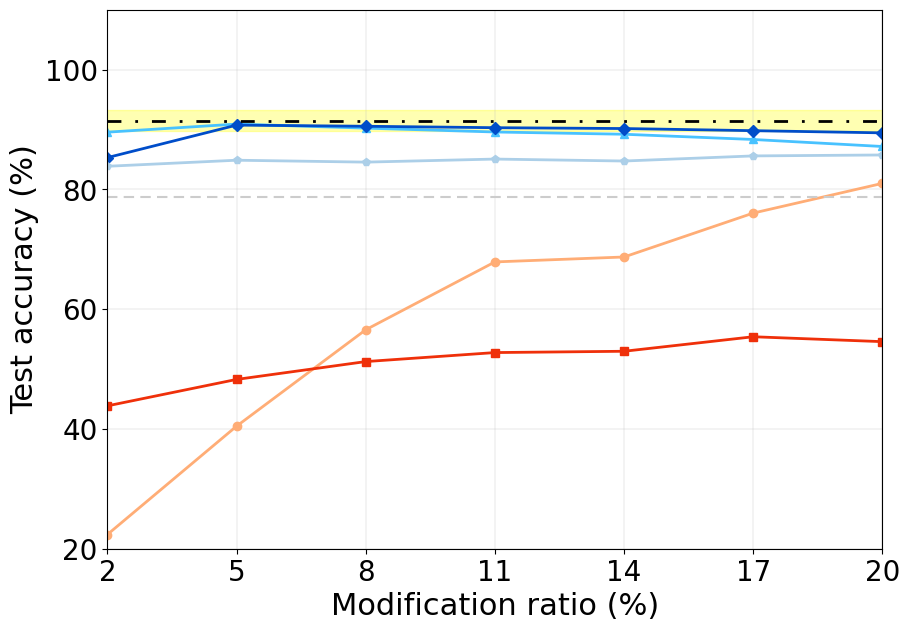

In [120]:
import matplotlib.pyplot as plt

# Colors and markers
colors = ['#090446', '#786F52', '#F71735', '#FEB95F', '#000000', "#ED3D15", "#777777"]  # Example hex codes
colors = ['#48C2FF', '#004DC9', '#ACCFE8', '#FFAD76', '#EF300A', "#000000", "#CCCCCC"]  # Example hex codes
markers = ['o', 's', '^', 'D', 'p']  # Example marker styles

# Fontsize variable
fontsize = 20

# Abbreviation for brevity
pr_wo1 = ratio_list[:-1]*100
meal = mean_exclusive_acc_list
veal = var_exclusive_acc_list

# Creating the plots
plt.figure(figsize=(10, 7))
plt.plot(pr_wo1, meal[2,:], marker=markers[2], color=colors[0], label='Highest-k outputs', linewidth=2)
plt.plot(pr_wo1, meal[3,:], marker=markers[3], color=colors[1], label='Highest-k gradients', linewidth=2)
plt.plot(pr_wo1, meal[4,:], marker=markers[4], color=colors[2], label='Random', linewidth=2)
plt.plot(pr_wo1, meal[0,:], marker=markers[0], color=colors[3], label='Lowest-k outputs', linewidth=2)
plt.plot(pr_wo1, meal[1,:], marker=markers[1], color=colors[4], label='Lowest-k gradients', linewidth=2)

#
# plt.fill_between(pr_wo1, meal[0,:]-veal[0,:], meal[0,:]+veal[0,:], color=colors[3], alpha=0.2)
# plt.fill_between(pr_wo1, meal[1,:]-veal[1,:], meal[1,:]+veal[1,:], color=colors[4], alpha=0.2)
# plt.fill_between(pr_wo1, meal[2,:]-veal[2,:], meal[2,:]+veal[2,:], color=colors[0], alpha=0.2)
# plt.fill_between(pr_wo1, meal[3,:]-veal[3,:], meal[3,:]+veal[3,:], color=colors[1], alpha=0.2)
# plt.fill_between(pr_wo1, meal[4,:]-veal[4,:], meal[4,:]+veal[4,:], color=colors[2], alpha=0.2)


# Horizontal values
plt.axhline(y=original_acc, color=colors[5], linestyle='-.', dashes=(5, 5, 1, 5), linewidth=2)
plt.fill_between(pr_wo1, original_acc*0.98, original_acc*1.02, color="yellow", alpha=0.3)
plt.axhline(y=plain_influence_acc, color=colors[6], linestyle='--', dashes=(5, 3), label="Naive influence function")

# Adding legend and labels with specified fontsize
plt.xlabel('Modification ratio (%)', fontsize=fontsize+2)
plt.ylabel('Test accuracy (%)', fontsize=fontsize+2)
# plt.legend(fontsize=fontsize-1, ncol=2, columnspacing=0.9)

# Adding ticks
plt.xticks(pr_wo1, fontsize=fontsize)
plt.xlim((np.min(pr_wo1), np.max(pr_wo1)))
plt.yticks(range(0, 101, 20), fontsize=fontsize)
plt.ylim((20, 110))

plt.grid(True, linewidth=0.25, color="#BBBBBB")

# Display the plot
plt.savefig('test_accuracy.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()